In [3]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report
from sklearn.feature_selection import mutual_info_classif
from kneed import KneeLocator
import warnings
from sklearn.metrics import roc_auc_score, roc_curve
warnings.filterwarnings("ignore")

In [ ]:
# import dataset
df=pd.read_csv('Dataset.csv')
df.head(1)

Text(0, 0.5, 'conversions')

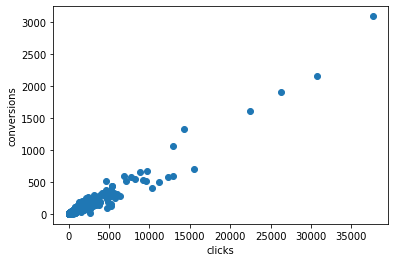

In [95]:
# Visualize relation between clicks and conversions
plt.scatter(df['clicks'],df['conversions'])
plt.xlabel('clicks')
plt.ylabel('conversions')

In [96]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6415 entries, 0 to 6414
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   offerId       6415 non-null   object 
 1   title         6415 non-null   object 
 2   description   6415 non-null   object 
 3   itemGroupId   6166 non-null   float64
 4   price         6415 non-null   object 
 5   productTypes  6411 non-null   object 
 6   sizes         6020 non-null   object 
 7   color         2265 non-null   object 
 8   brand         754 non-null    object 
 9   clicks        6415 non-null   int64  
 10  conversions   6415 non-null   float64
dtypes: float64(2), int64(1), object(8)
memory usage: 551.4+ KB


In [97]:
# Check the number of  unique values in every column of the dataset
unique=[len(df[i].unique()) for i in df.columns]
df_unique=pd.DataFrame(index=df.columns)
df_unique['unique']=unique
df_unique

,unique
offerId,6415
title,6415
description,633
itemGroupId,452
price,35
productTypes,47
sizes,130
color,17
brand,2
clicks,547


In [98]:
# Remove the unnecessary columns
df.drop(['offerId','title'],axis=1,inplace=True)
df_unique.drop(['offerId','title'],axis=0,inplace=True)
df.head(1)

,description,itemGroupId,price,productTypes,sizes,color,brand,clicks,conversions
0,Calling all leopard loving ladies! We've got t...,7.124849e+12,"{'value': '25.00', 'currency': 'GBP'}",['Tough Phone Case'],['Samsung Galaxy S21 Plus'],NaN,NaN,0,0.0


In [99]:
# Check the dataset for % missing values
df.isnull().sum()/len(df)

description     0.000000
itemGroupId     0.038815
price           0.000000
productTypes    0.000624
sizes           0.061574
color           0.646921
brand           0.882463
clicks          0.000000
conversions     0.000000
dtype: float64

In [100]:
one_hot=['color'] # Make a list of colums on which we have to do encoding
# Capture the missing data information
df['color_nan']=np.where(df['color'].isnull(),1,0)
df['brand_nan']=np.where(df['brand'].isnull(),1,0)
# create a new category for missing values in color column
df['color'].loc[df['color'].isnull()]='Other'
df.drop('brand',axis=1,inplace=True)
df.head(1)

,description,itemGroupId,price,productTypes,sizes,color,clicks,conversions,color_nan,brand_nan
0,Calling all leopard loving ladies! We've got t...,7.124849e+12,"{'value': '25.00', 'currency': 'GBP'}",['Tough Phone Case'],['Samsung Galaxy S21 Plus'],Other,0,0.0,1,1


In [101]:
# number of characters in the description may have an impact on clicks
df['description']=df['description'].apply(lambda x:len(x))
df.head(1)

,description,itemGroupId,price,productTypes,sizes,color,clicks,conversions,color_nan,brand_nan
0,767,7.124849e+12,"{'value': '25.00', 'currency': 'GBP'}",['Tough Phone Case'],['Samsung Galaxy S21 Plus'],Other,0,0.0,1,1


In [102]:
# Check the dataset for % missing values
df.isnull().sum()/len(df)

description     0.000000
itemGroupId     0.038815
price           0.000000
productTypes    0.000624
sizes           0.061574
color           0.000000
clicks          0.000000
conversions     0.000000
color_nan       0.000000
brand_nan       0.000000
dtype: float64

In [103]:
mean_encoding=['itemGroupId']# Make a list of colums on which we have to do mean encoding
#df['itemGroupId'].fillna('other',inplace=True)
df.dropna(inplace=True)
# Extract the price value
df['price']=df['price'].apply(lambda x: x.replace("'", "\""))
df['price']=[float(json.loads(i)['value']) for i in df['price']]
df.head(1)

,description,itemGroupId,price,productTypes,sizes,color,clicks,conversions,color_nan,brand_nan
0,767,7.124849e+12,25.0,['Tough Phone Case'],['Samsung Galaxy S21 Plus'],Other,0,0.0,1,1


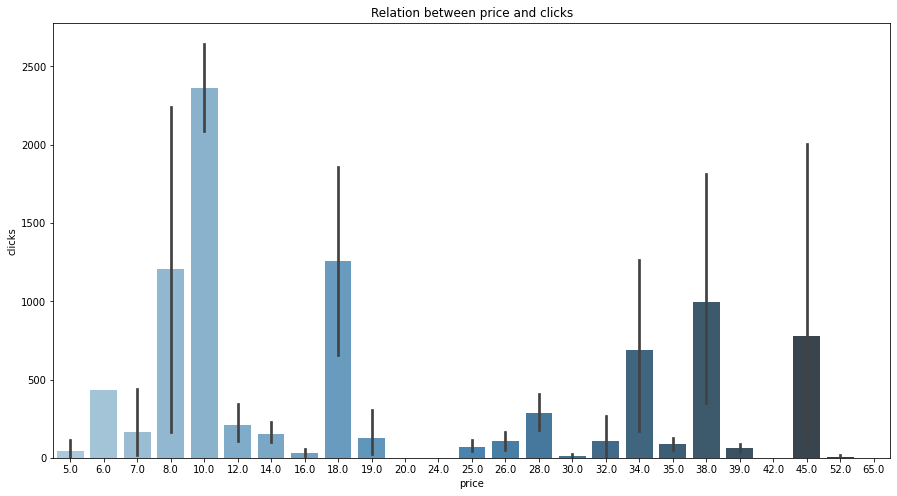

Text(0.5, 1.0, 'Relation between price and conversions')

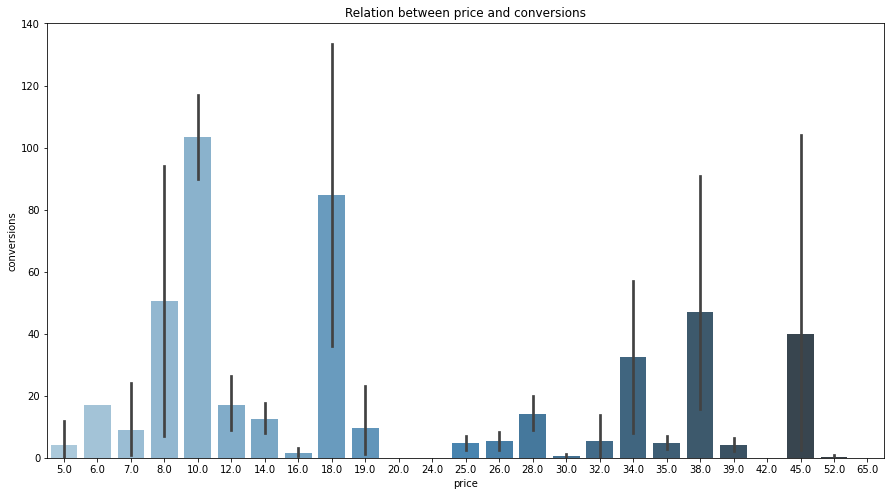

In [104]:
# plot graphs to see the impact of price on number of clicks and conversions
plt.figure(figsize=(15,8))
sns.barplot(x=df['price'], y=df['clicks'], data=df, palette='Blues_d')
plt.title('Relation between price and clicks')
plt.show()
plt.figure(figsize=(15,8))
sns.barplot(x=df['price'], y=df['conversions'], data=df, palette='Blues_d')
plt.title('Relation between price and conversions')

In [105]:
# Extract the productTypes and sizes values from the columns
to_remove=["[","]","'"," "]
for i in to_remove:
    df['productTypes']=df['productTypes'].apply(lambda x: str(x).replace(i, ""))
    df['sizes']=df['sizes'].apply(lambda x: str(x).replace(i, ""))
mean_encoding.append('productTypes')
mean_encoding.append('sizes')
df.head(1)

,description,itemGroupId,price,productTypes,sizes,color,clicks,conversions,color_nan,brand_nan
0,767,7.124849e+12,25.0,ToughPhoneCase,SamsungGalaxyS21Plus,Other,0,0.0,1,1


In [106]:
df.describe()

,description,itemGroupId,price,clicks,conversions,color_nan,brand_nan
count,6020.000000,6.020000e+03,6020.00000,6020.000000,6020.000000,6020.000000,6020.000000
mean,747.773754,5.600504e+12,24.13804,100.478738,6.842359,0.648007,0.886213
std,194.406255,1.381224e+12,9.97923,922.954049,69.380430,0.477632,0.317579
min,279.000000,8.300489e+09,5.00000,0.000000,0.000000,0.000000,0.000000
25%,636.000000,4.434887e+12,16.00000,0.000000,0.000000,0.000000,1.000000
50%,756.000000,6.226064e+12,25.00000,0.000000,0.000000,1.000000,1.000000
75%,902.000000,6.821590e+12,25.00000,4.000000,0.000000,1.000000,1.000000
max,1324.000000,7.139844e+12,65.00000,37686.000000,3085.000000,1.000000,1.000000


In [107]:
# convert the clicks column into ether clicked(1) or not clicked(0)
df.loc[df['clicks']>0,'clicks']=1
df.head(1)

,description,itemGroupId,price,productTypes,sizes,color,clicks,conversions,color_nan,brand_nan
0,767,7.124849e+12,25.0,ToughPhoneCase,SamsungGalaxyS21Plus,Other,0,0.0,1,1


In [108]:
# convert the conversions into 3 different categories: 0=None, 1=Low Conversion and 2=High conversion
df.loc[df['conversions']==0,'conversions_new']=0
df.loc[(df['conversions']>0) & (df['conversions']<20),'conversions_new']=1
df.loc[(df['conversions']>=20),'conversions_new']=2
df.head(1)

,description,itemGroupId,price,productTypes,sizes,color,clicks,conversions,color_nan,brand_nan,conversions_new
0,767,7.124849e+12,25.0,ToughPhoneCase,SamsungGalaxyS21Plus,Other,0,0.0,1,1,0.0


In [109]:
#one_hot_encoding of columns
for i in one_hot:
    one_hot_dummies=pd.get_dummies(df[i],drop_first=True)
    df=pd.concat([df,one_hot_dummies],axis=1)
    df.drop(i,axis=1,inplace=True)
df.head(1)

,description,itemGroupId,price,productTypes,sizes,clicks,conversions,color_nan,brand_nan,conversions_new,...,Nude,Other,Sand,White,black,blue,green,nude,pink,white
0,767,7.124849e+12,25.0,ToughPhoneCase,SamsungGalaxyS21Plus,0,0.0,1,1,0.0,...,0,1,0,0,0,0,0,0,0,0


In [110]:
#mean_encoding of columns
for i in mean_encoding:
    mean_encode=df.groupby(i)['clicks'].mean().to_dict()
    df[i]=df[i].map(mean_encode)
df.head(1)

,description,itemGroupId,price,productTypes,sizes,clicks,conversions,color_nan,brand_nan,conversions_new,...,Nude,Other,Sand,White,black,blue,green,nude,pink,white
0,767,0.0,25.0,0.411431,0.286822,0,0.0,1,1,0.0,...,0,1,0,0,0,0,0,0,0,0


In [111]:
df_cluster=df.drop(['clicks','conversions'],axis=1)
df_cluster.head(1)

,description,itemGroupId,price,productTypes,sizes,color_nan,brand_nan,conversions_new,Black,Khaki,Nude,Other,Sand,White,black,blue,green,nude,pink,white
0,767,0.0,25.0,0.411431,0.286822,1,1,0.0,0,0,0,1,0,0,0,0,0,0,0,0


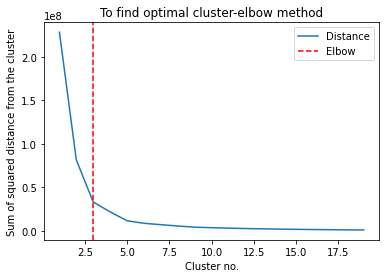

In [112]:
# Identify the presence of number of clusters in the dataset
dis=[]
for i in range(1, 20):
    km = KMeans(n_clusters=i, random_state=42)
    km.fit(df_cluster)
    dis.append(km.inertia_)
kl = KneeLocator(range(1, 20), dis, direction='decreasing', curve='convex')
km_cluster = kl.knee
# Plot the sum of squared distance from the cluster center and number of clusters for visualisation
plt.plot(range(1, 20), dis)
plt.axvline(kl.knee, c='r', linestyle='--')
plt.legend(['Distance', 'Elbow'])
plt.xlabel('Cluster no.')
plt.ylabel('Sum of squared distance from the cluster')
plt.title('To find optimal cluster-elbow method')
plt.show()

In [113]:
# Add extra feature in the dataset by the cluster information
km = KMeans(n_clusters=km_cluster, random_state=42)
y_km = km.fit_predict(df_cluster)
df['cluster']=y_km
df.head()

,description,itemGroupId,price,productTypes,sizes,clicks,conversions,color_nan,brand_nan,conversions_new,...,Other,Sand,White,black,blue,green,nude,pink,white,cluster
0,767,0.000000,25.0,0.411431,0.286822,0,0.0,1,1,0.0,...,1,0,0,0,0,0,0,0,0,2
1,633,0.888889,35.0,0.826979,0.888889,1,0.0,0,1,0.0,...,0,0,0,1,0,0,0,0,0,2
2,944,0.500000,25.0,0.411431,0.389610,0,0.0,0,1,0.0,...,0,0,0,0,0,0,0,0,0,1
3,734,0.204082,19.0,0.264075,0.333333,1,0.0,1,0,0.0,...,1,0,0,0,0,0,0,0,0,2
4,926,0.750000,25.0,0.411431,0.493506,1,0.0,1,1,0.0,...,1,0,0,0,0,0,0,0,0,1


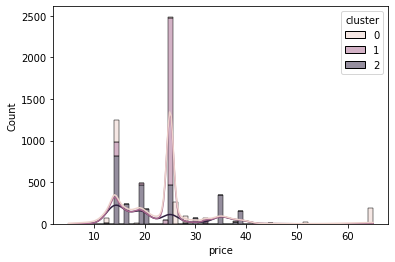

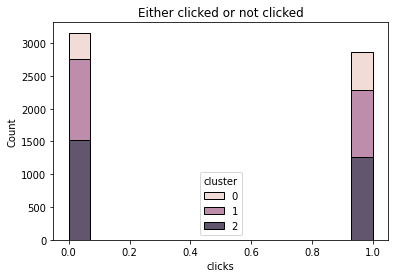

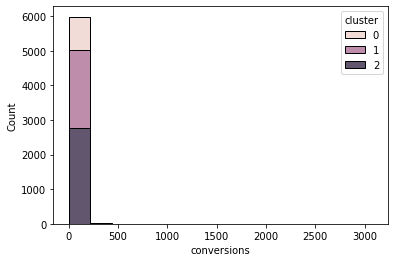

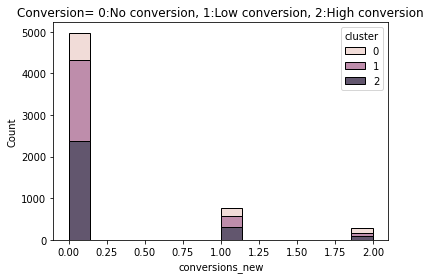

In [114]:
# Visualize the features
sns.histplot(data=df, x='price', hue='cluster', multiple='stack',kde=True)
plt.show()
sns.histplot(data=df, x='clicks', hue='cluster', multiple='stack')
plt.title('Either clicked or not clicked')
plt.show()
sns.histplot(data=df, x='conversions', hue='cluster', multiple='stack')
plt.show()
sns.histplot(data=df, x='conversions_new', hue='cluster', multiple='stack')
plt.title('Conversion= 0:No conversion, 1:Low conversion, 2:High conversion')
plt.show()

In [115]:
print('Number of clicks happend:',len(df.loc[df['clicks']>0]))
print('Number of conversions after the click ',len(df.loc[(df['clicks']>0)&(df['conversions']>0)]))
print('Number of conversions before the click ',len(df.loc[(df['clicks']==0)&(df['conversions']>0)]))

Number of clicks happend: 2860
Number of conversions after the click  1042
Number of conversions before the click  0


In [116]:
df1=df.loc[df['clicks']>0]
df1.reset_index(drop=True,inplace=True)
df1.head(1)

,description,itemGroupId,price,productTypes,sizes,clicks,conversions,color_nan,brand_nan,conversions_new,...,Other,Sand,White,black,blue,green,nude,pink,white,cluster
0,633,0.888889,35.0,0.826979,0.888889,1,0.0,0,1,0.0,...,0,0,0,1,0,0,0,0,0,2


In [117]:
# Extract dependent and independent features from the dataset
y1=df['clicks'] # To identify if click happend
x1=df.drop(['clicks','conversions_new','conversions'],axis=1)
y2=df1['conversions_new'] # to see if the conversion rate is high or low for the click
x2=df1.drop(['clicks','conversions_new','conversions'],axis=1)

In [118]:
x1.head(1)

,description,itemGroupId,price,productTypes,sizes,color_nan,brand_nan,Black,Khaki,Nude,Other,Sand,White,black,blue,green,nude,pink,white,cluster
0,767,0.0,25.0,0.411431,0.286822,1,1,0,0,0,1,0,0,0,0,0,0,0,0,2


In [119]:
# Check the significance of the features in predicting dependent variable
mutual_info = mutual_info_classif(x1, y1)
feature_df = pd.DataFrame(mutual_info , index=x1.columns)
feature_df.sort_values(0)

,0
pink,0.000000
nude,0.000000
blue,0.000000
Khaki,0.000000
White,0.003293
cluster,0.003671
brand_nan,0.003694
Sand,0.004203
black,0.004690
color_nan,0.007338


In [120]:
x2.head(1)

,description,itemGroupId,price,productTypes,sizes,color_nan,brand_nan,Black,Khaki,Nude,Other,Sand,White,black,blue,green,nude,pink,white,cluster
0,633,0.888889,35.0,0.826979,0.888889,0,1,0,0,0,0,0,0,1,0,0,0,0,0,2


In [121]:
# Check the significance of the features in predicting dependent variable
mutual_info2 = mutual_info_classif(x2, y2)
feature_df2 = pd.DataFrame(mutual_info2 , index=x2.columns)
feature_df2.sort_values(0)

,0
nude,0.000000
color_nan,0.000000
Khaki,0.000000
Other,0.000000
White,0.000000
black,0.000000
Nude,0.000104
brand_nan,0.000724
pink,0.001139
white,0.003747


In [122]:
# split the dataset into train and test
x_train1, x_test1, y_train1, y_test1 = train_test_split(x1, y1, test_size=0.3, random_state=0)
x_train2, x_test2, y_train2, y_test2 = train_test_split(x2, y2, test_size=0.3, random_state=0)
weight1={0: 0.4807783578547698, 1: 0.5192216421452301}
weight2={0.0: 0.0984015984015984, 1.0: 0.26823176823176825, 2.0: 0.6333666333666333}
# Normalize the dependent variables
sc1=StandardScaler()
sc2=StandardScaler()
x_train1=sc1.fit_transform(x_train1)
x_train2=sc2.fit_transform(x_train2)
# identify the best parameters for the models
param_test1 = {'class_weight' : [weight1,'balanced',None]}
model_1 = GridSearchCV(LogisticRegression(random_state=0), param_grid = param_test1, scoring='balanced_accuracy', cv=10)
param_test2 = {'class_weight' : [weight2,'balanced',None],'multi_class':['multinomial','ovr']}
model_2 = GridSearchCV(LogisticRegression(random_state=0), param_grid = param_test2, scoring='balanced_accuracy', cv=10)
# fit the models
model_1.fit(x_train1, y_train1)
model_2.fit(x_train2, y_train2)
# perform prediction
predictions_LR1 = model_1.predict(sc1.transform(x_test1))
predictions_LR2 = model_2.predict(sc2.transform(x_test2))
print('Model_1')
print('Logistic regression best parameters',model_1.best_params_)
print('\nLogistic regression accuracy:', accuracy_score(predictions_LR1, y_test1))
print('\nConfusion matrix:')
print(confusion_matrix(y_test1,predictions_LR1))
print('\nClassification report:')
print(classification_report(y_test1,predictions_LR1))
print('Model_2')
print('Logistic regression best parameters',model_2.best_params_)
print('\nLogistic regression accuracy:', accuracy_score(predictions_LR2, y_test2))
print('\nConfusion matrix:')
print(confusion_matrix(y_test2,predictions_LR2))
print('\nClassification report:')
print(classification_report(y_test2,predictions_LR2))

Model_1
Logistic regression best parameters {'class_weight': None}

Logistic regression accuracy: 0.8133997785160576

Confusion matrix:
[[803 169]
 [168 666]]

Classification report:
              precision    recall  f1-score   support

           0       0.83      0.83      0.83       972
           1       0.80      0.80      0.80       834

    accuracy                           0.81      1806
   macro avg       0.81      0.81      0.81      1806
weighted avg       0.81      0.81      0.81      1806

Model_2
Logistic regression best parameters {'class_weight': 'balanced', 'multi_class': 'ovr'}

Logistic regression accuracy: 0.5128205128205128

Confusion matrix:
[[331 113 106]
 [ 79  51  94]
 [ 11  15  58]]

Classification report:
              precision    recall  f1-score   support

         0.0       0.79      0.60      0.68       550
         1.0       0.28      0.23      0.25       224
         2.0       0.22      0.69      0.34        84

    accuracy                          

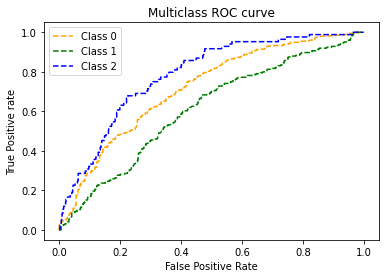

In [123]:
# check the model performance
pred_prob = model_2.predict_proba(sc2.transform(x_test2))
fpr = {}
tpr = {}
thresh ={}
for i in range(len(y_test2.unique())):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test2, pred_prob[:,i], pos_label=i)   
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300); 